In [1]:
# some times Tensorflow has problems with memory growth, if that case happens run this cell.
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
        #tf.config.experimental.set_virtual_device_configuration(gpu, 
        #[tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4096)])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [2]:
import sys
import os
import argparse
import json

from sklearn.model_selection import train_test_split
import datetime as dt

from core.data.data_loader import *
from core.models.lstm import ModelLSTM, ModelLSTMParallel, GaussianLSTM
from core.models.cnn import ModelCNN, ModelCNNParallel
from core.models.mlp import ModelMLP, GaussianMLP
from core.models.rnn import ModelRNN

from core.utils.metrics import *
from core.utils.utils import *

import numpy as np


In [3]:
def manage_models(config):
    
    type_model = config['model']['name']
    model = None

    if type_model == 'lstm': #simple LSTM
        model = ModelLSTM(config)
    elif type_model == 'gaussian-lstm':
        model = GaussianLSTM(config)       
    elif type_model == 'lstm-parallel':
        model = ModelLSTMParallel(config)
    elif type_model == 'cnn':
        model = ModelCNN(config)
    elif type_model == 'cnn-parallel':
        model = ModelCNNParallel(config)        
    elif type_model == 'mlp':
        model = ModelMLP(config)
    elif type_model == 'gaussian-mlp':
        model = GaussianMLP(config)        
    elif type_model == 'simple-rnn':
        model = ModelRNN(config)        

    return model


In [5]:
# reading config file
# load differents configurations 
#configs = json.load(open('config_lstm_parallel_internal.json', 'r'))
configs = json.load(open('config_lstm_parallel_internal_all.json', 'r'))
#configs = json.load(open('config_mlp_gaussian.json', 'r'))
#configs = json.load(open('config_lstm_gaussian.json', 'r'))


# create defaults dirs
output_bin = configs['paths']['bin_dir']
output_path = configs['paths']['save_dir']
output_logs = configs['paths']['log_dir']
time_steps =  configs['model']['layers'][0]['input_timesteps']  # the number of points or hits
t_features = configs['model']['layers'][0]['input_features']  # the number of features of a tensor
n_features = configs['data']['features']  # the number of features of data input
data_file = configs['data']['filename']
split = configs['data']['train_split']  # the number of features of each hits
cylindrical = configs['data']['cylindrical']  # set to polar or cartesian coordenates
normalise = configs['data']['normalise'] 
num_hits = configs['data']['num_hits']
type_norm = configs['data']['type_norm']
points_3d = configs['data']['points_3d'] # what kind of points: (rho, eta, phi) or (eta, phi)    

type_model = configs['model']['name']
optim = configs['model']['optimizer']
arch = configs['model']['layers']
is_parallel = configs['model']['isparallel']
over_write = configs['model']['overwrite']

loadModel = configs['training']['load_model']
validation_split = configs['training']['validation']
epochs = configs['training']['epochs']
batch = configs['training']['batch_size']
shuffle_train = configs['training']['shuffle']

#create a encryp name for dataset
path_to, filename = os.path.split(data_file)

orig_ds_name = filename

encryp_ds_name = get_unique_name(orig_ds_name)
decryp_ds_name = get_decryp_name(encryp_ds_name)

output_encry = os.path.join(output_path, encryp_ds_name)  
if os.path.isdir(output_bin) == False:
    os.mkdir(output_bin)

if os.path.isdir(output_path) == False: 
    os.mkdir(output_path)

if os.path.isdir(output_encry) == False: 
    os.mkdir(output_encry)

if os.path.isdir(output_logs) == False:
    os.mkdir(output_logs)        
print('Readed')

Readed


In [6]:
# prepare data set
if type_norm == "zscore":
    kind_norm = KindNormalization.Zscore
elif type_norm == "maxmin":
    kind_norm = KindNormalization.Scaling
data = Dataset(data_file, split, cylindrical, num_hits, kind_norm, points_3d=points_3d)

X_train, y_train = data.get_training_data(n_hit_in=time_steps, n_hit_out=1,
                             n_features=n_features, normalise=normalise)

print('[Data] Shape supervised: X%s y%s :' % (X_train.shape, y_train.shape))
X_train.head()

[Data] Data loaded from  /data/track-ml/bracis/datasets/eta_n0.5-0.5_phi_n0.5-0.5/eta_n0.5-0.5_phi_n0.5-0.5_20200518171238_tracks.csv
[Data] Data set shape  (30000, 30)
[Data] Data train shape  (24000, 30)
[Data] Data test shape  (6000, 30)
[Data] Data coordinates  cylin
[Data] Data normalization type  KindNormalization.Scaling
[Data] Shape supervised: X(144000, 12) y(144000, 3) :


,0,1,2,3,4,5,6,7,8,9,10,11
0,-0.994612,0.191916,0.056131,-0.834097,0.273532,0.054053,-0.850836,0.208417,0.051335,-0.844055,0.084845,0.045496
1,-0.759050,0.217656,0.052578,-0.643922,0.282194,0.050409,-0.665107,0.213588,0.046944,-0.585823,0.089207,0.038217
2,-0.489969,0.225938,0.048941,-0.411146,0.286473,0.046023,-0.356408,0.217336,0.039704,-0.302234,0.091680,0.030187
3,-0.160610,0.230030,0.044562,-0.024250,0.289575,0.038789,-0.017396,0.219461,0.031717,0.090440,0.092994,0.019014
4,0.386816,0.232996,0.037341,0.400637,0.291333,0.030809,0.452019,0.220590,0.020604,0.534277,0.094430,0.006020


In [7]:
if normalise:
    print('[Data] Saving distributions at ', output_encry)
    data.save_scale_param(output_encry)
    
if type_model == 'lstm' or type_model == 'cnn' or type_model == 'gaussian-lstm':
    if not is_parallel:
        X_train_ = data.reshape3d(X_train, time_steps, t_features)
    print('[Data] Shape Tensor X_train.shape:', X_train.shape)
elif type_model == 'lstm-parallel' or type_model == 'cnn-parallel':
    if not is_parallel:
        print('DEBUG')

    X_train_ = np.reshape(X_train.values, (X_train.shape[0], time_steps, n_features))
    #X_train = data.reshape3d(X_train, time_steps, n_features)
    y_train_ = np.reshape(y_train.values, (y_train.shape[0], n_features))

    X1 = X_train_[:,:,0].reshape(X_train_.shape[0], X_train_.shape[1], t_features)
    X2 = X_train_[:,:,1].reshape(X_train_.shape[0], X_train_.shape[1], t_features)
    X3 = X_train_[:,:,2].reshape(X_train_.shape[0], X_train_.shape[1], t_features)

    Y1 = y_train_[:,0].reshape(y_train_.shape[0],  t_features)
    Y2 = y_train_[:,1].reshape(y_train_.shape[0],  t_features)
    Y3 = y_train_[:,2].reshape(y_train_.shape[0],  t_features)

    X_train_ = [X1, X2, X3]

#print('[Data] Shape Tensor X_train.shape:', X_train.shape)
print('[Data] Shape Tensor y_train.shape:', y_train_.shape)


[Data] Saving distributions at  results/MEnGHa5DCmJGE9C9BpAg4i
[Data] Shape Tensor y_train.shape: (144000, 3)


In [9]:
#!pip install livelossplot --quiet
import keras
from keras.callbacks import EarlyStopping, ModelCheckpoint, TerminateOnNaN
from livelossplot import PlotLossesKeras


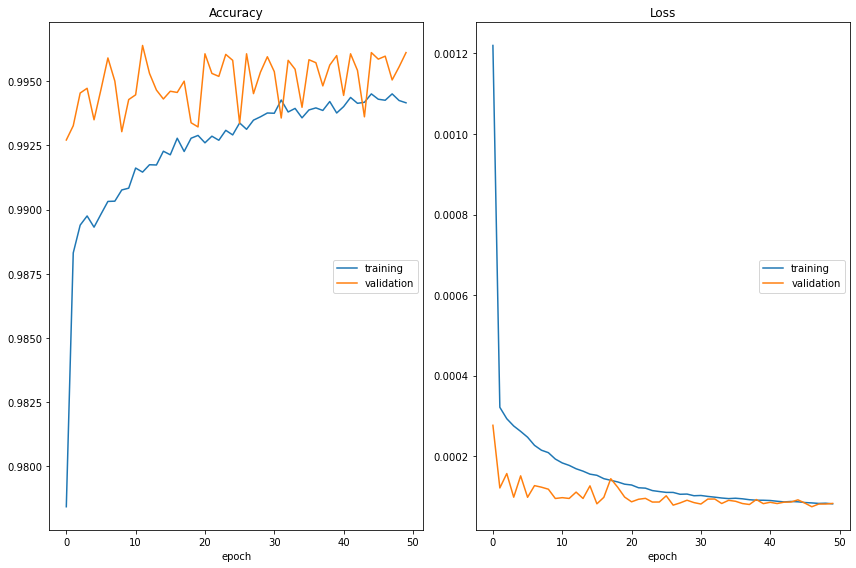

Accuracy
	training         	 (min:    0.978, max:    0.995, cur:    0.994)
	validation       	 (min:    0.993, max:    0.996, cur:    0.996)
Loss
	training         	 (min:    0.000, max:    0.001, cur:    0.000)
	validation       	 (min:    0.000, max:    0.000, cur:    0.000)
[Model] Model for inference saved at /data/track-ml/eramia/compiled/model-lstm-parallel-MEnGHa5DCmJGE9C9BpAg4i-coord-cylin-normalise-true-epochs-30-batch-60.h5
[Model] Model training stopped at 0 epoch
[Model] Training Completed. Model h5 saved as /data/track-ml/eramia/compiled/model-lstm-parallel-MEnGHa5DCmJGE9C9BpAg4i-coord-cylin-normalise-true-epochs-30-batch-60.h5
[Model] Model train with structure: [<tf.Tensor 'input_4:0' shape=(None, 4, 1) dtype=float32>, <tf.Tensor 'input_5:0' shape=(None, 4, 1) dtype=float32>, <tf.Tensor 'input_6:0' shape=(None, 4, 1) dtype=float32>]
Time taken: 0:19:22.226278
Time taken: 0:19:22.228899


In [10]:
# training model
model = manage_models(configs)

if model is None:
    print('Please instance model')

show_metrics = configs['training']['show_metrics']
report = ""

if cylindrical:
    coord = 'cylin'
else:
    coord = 'xyz'

ident_name = model.name + "_" + coord 
timer = Timer()

# configure callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=50, verbose=1)
terminate_nan = TerminateOnNaN()
plotlosses = PlotLossesKeras()

if not loadModel:
    if not over_write:
        # if exist, please used the compiled model!
        if model.exist_model(model.save_fnameh5):
            print("[Warning] Please there is a previous model compiled (%s) for %s file." 
                % (model.save_fnameh5, data_file))

    model.build_model()
    save_fname = os.path.join(output_encry, 'architecture_%s.png' % ident_name)
    model.save_architecture(save_fname) 

    timer.start()
    
    check_point = ModelCheckpoint(filepath=model.save_fnameh5, monitor='val_loss', 
                    mode='min', save_best_only=True)
    # live training
    history = model.train(
        x=X_train_,
        y=y_train_,
        validation=0.3,
        epochs=50,
        verbose=False,
        batch_size=60,
        shuffle=shuffle_train,
        callbacks=[early_stop, plotlosses, terminate_nan]
    )
    if show_metrics:
        report = evaluate_training(history, output_encry, ident_name)
    timer.stop()
elif loadModel:       
    if not model.load_model():
        print ('[Error] please change the config file : load_model')
#session.close()

accuracy: 0.9961110949516296, loss: 8.26694376883097e-05, val_acc: 0.9961110949516296, val_loss: 8.26694376883097e-05


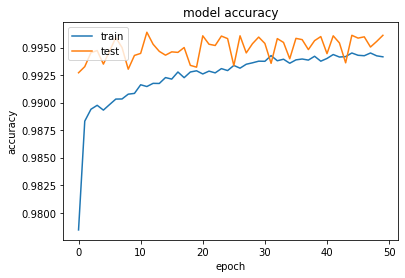

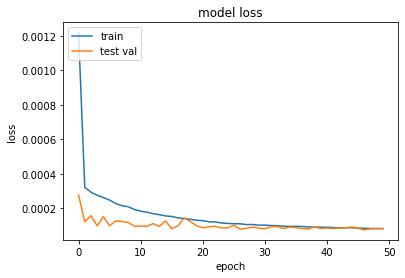

[Output] Metrics saved at %s results/MEnGHa5DCmJGE9C9BpAg4i/evaluation-loss_lstm-parallel_cylin.png
Final cost: 0.0001


In [11]:
#history.history
report = evaluate_training(history, output_encry, ident_name)
print('Final cost: {0:.4f}'.format(history.history['loss'][-1]))
# 0.002, 0.0011
# gaussian 2.2359
# lstm
#  accuracy: 0.9964583516120911, loss: 0.00020314622088335454, val_acc: 0.9964583516120911, val_loss: 0.00020314622088335454

In [12]:

# save results in a file    
orig_stdout = sys.stdout
f = open(os.path.join(output_encry, 'results-train.txt'), 'a')
sys.stdout = f

now = dt.datetime.now()
print("[Output] Train results ")
print("---Parameters--- ")
print("\t Model Name        : ", model.name)
print("\t Dataset           : ", model.orig_ds_name)
print("\t Total tracks      : ", len(X_train))
print("\t Path saved        : ", model.save_fnameh5) 
print("\t Coordenate type   : ", coord) 
print("\t Compiled date     : %s taken %s" % (timer.start_dt.strftime("%d/%m/%Y %H:%M:%S"), timer.taken()))    
print("\t Model scaled      : ", model.normalise)
print("\t Model scaled      : ", type_norm)
print("\t Model Optimizer   : ", optim)
print("\t Model batch_size  : ", batch)
print("\t Model epochs      : %s  stopped %s " % (epochs, model.stopped_epoch))
print("\t Accuracy          : ", report)
print("\t Architecture      : ", arch)

sys.stdout = orig_stdout
f.close()    

print('[Output] All results saved at %s directory it results-train.txt file. Please use notebooks/plot_prediction.ipynb' % output_encry)    


[Output] All results saved at results/MEnGHa5DCmJGE9C9BpAg4i directory it results-train.txt file. Please use notebooks/plot_prediction.ipynb
